Comparing RMSD using JAX with MDAnalysis 

In [1]:
import MDAnalysis as mda
from MDAnalysis.analysis import rms
import numpy as np
import matplotlib.pyplot as plt
import time
import pickle
import sys

sys.path.append("../")
from dmap_JAX import rmsd_jax as rjax
from dmap_JAX import dMap_jax as djax

import jax.numpy as jnp

#### plot settings

In [2]:
showPlots=1
useMagics=1
if useMagics:
    %matplotlib inline
    #%matplotlib notebook
    %load_ext autoreload
    %autoreload 2
    %reload_ext autoreload
    
font = {'weight' : 'normal',
        'size'   : 25}

plt.rc('font', **font)

#### load integrin trajectories

In [3]:
universe_cg_traj_reps = []


for rep in [2]:

    file_cg_traj_break_legs_rep = '../../../analysis-integrin/archive-integrin/integrin-data/grains_cg/inputs_lammps/break_legs/rep_'+str(rep)+ '/dump22_mda'

    
    #file_cg_break_legs_top_rep = '../../../analysis-integrin/archive-integrin/integrin-data/grains_cg/inputs_lammps/break_legs/rep_'+str(rep)+ '/data.nvt'


    #topology_cg_break_legs_top_rep = mda.topology.LAMMPSParser.DATAParser(file_cg_break_legs_top_rep).parse()

    universe_cg_traj_reps.append( mda.Universe(file_cg_traj_break_legs_rep + '.pdb', file_cg_traj_break_legs_rep + '.xtc'))

    #universe_cg_traj_reps.append( mda.Universe(topology_cg_break_legs_top_rep, file_cg_traj_break_legs_rep + '.dcd', 
    #                                           topology_format="LAMMPS", format="LAMMPS") )
    

/work2/03273/tg825722/shared-folder-siva/software/mconda/envs/djax/lib/python3.11/site-packages/MDAnalysis/topology/PDBParser.py:331: UserWarning: Element information is missing, elements attribute will not be populated. If needed these can be guessed using MDAnalysis.topology.guessers.
  warnings.warn("Element information is missing, elements attribute "
/work2/03273/tg825722/shared-folder-siva/software/mconda/envs/djax/lib/python3.11/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: X
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))


#### catenate all trajectories

In [4]:
#### merge trajs (Using MDAnalysis version 2.5.0)
lag_n = 800 # skip frames; if needed 
test_trajs = jnp.concatenate([x.trajectory.timeseries()[1::lag_n] for x in universe_cg_traj_reps])


In [5]:
print(test_trajs.shape)
#test_trajs

(500, 300, 3)


RMSD calculations using JAX

Run RMSD

In [6]:
# calculate pairwise RMSD
start = time.time()

# Adjust batch size depending on available memory. batch size implies the number of
# reference frames used for computing RMSD-RMSD in each batch.
rjax.run_rmsd(jnp.array(test_trajs), 
              batch_ref_frame_size=50, 
              nref_frames=test_trajs.shape[0] + 1, 
              output_file_prefix="test_outputdata/test_pairrmsd_")

print("RMSD calculations finished in {} seconds".format(time.time()-start))


running pairwise rmsd between same traj. Batch: 0
running pairwise rmsd between same traj. Batch: 50
running pairwise rmsd between same traj. Batch: 100
running pairwise rmsd between same traj. Batch: 150
running pairwise rmsd between same traj. Batch: 200
running pairwise rmsd between same traj. Batch: 250
running pairwise rmsd between same traj. Batch: 300
running pairwise rmsd between same traj. Batch: 350
running pairwise rmsd between same traj. Batch: 400
running pairwise rmsd between same traj. Batch: 450
RMSD calculations finished in 6.661959648132324 seconds


#### load RMSD, check properties if needed

In [7]:
# load saved RMSD into memory
sym_prmsd_jax = rjax.load_rmsd(nref_frames=test_trajs.shape[0] + 1,
                               batch_ref_frame_size=50, 
                               input_file_prefix="test_outputdata/test_pairrmsd_", 
                               tol=1e-5)


Checking if matrix is symmetric with tol:1e-05
diag_min: 0.0, diag_max: 0.0, 
 is_symmetric: True, diff_symmetric_min:0.0, diff_symmetric_max:0.0 


plot RMSD matrix

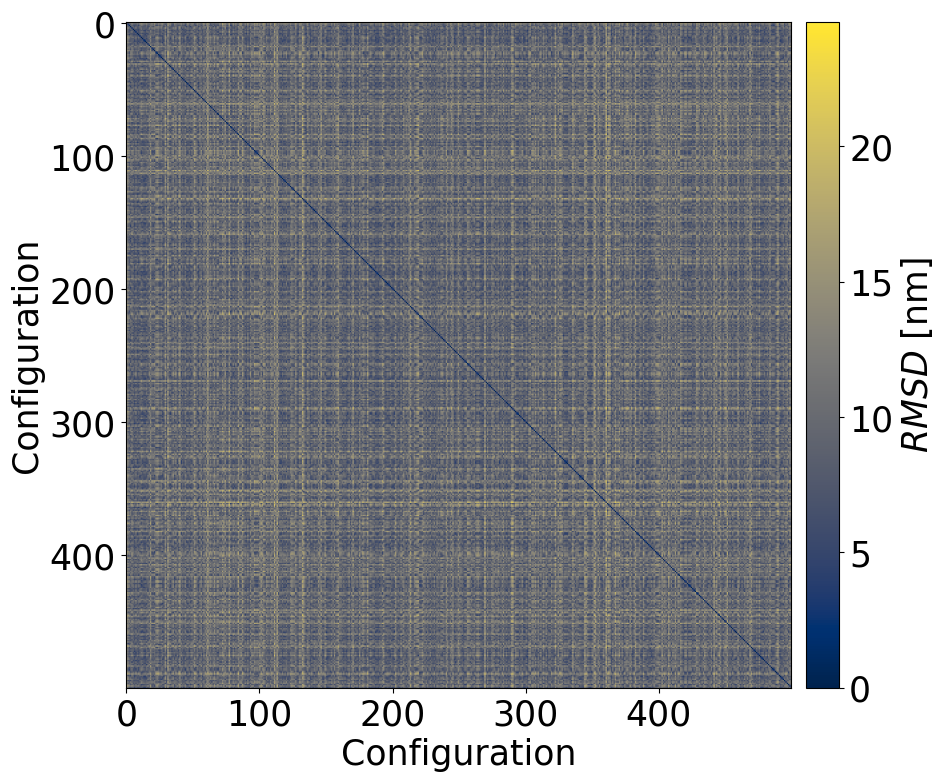

In [8]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, axes = plt.subplots(1,1, figsize = (10,10))

im1 = axes.imshow(sym_prmsd_jax, cmap='cividis', vmin=0)

axes.set_xlabel('Configuration')
axes.set_ylabel('Configuration')

#axes.set_xticks(ticks=list(np.arange(0,15000, 3000)), labels=list(np.arange(0,15000, 3000)))
#axes.set_yticks(ticks=list(np.arange(0,15000, 3000)), labels=list(np.arange(0,15000, 3000)))

divider = make_axes_locatable(axes)
cax = divider.append_axes('right', size='5%', pad=0.15)
fig.colorbar(im1, cax=cax, orientation='vertical', label='$RMSD$ [nm]')


fig.tight_layout()    
#fig.savefig('jax-rmsd-integrin-full.png',dpi=150)

#### test calculations using MDAnalysis

In [9]:
def run_mda_rmsd(mda_universe_traj):
    
    '''Run RMSD using MDA
    '''
        
    test_lag_n = 800
    n_frames = mda_universe_traj.trajectory.n_frames/test_lag_n
    n_frames = int(n_frames)
    test_mda_prmsd = np.zeros((n_frames, n_frames)) 
    ref_index = 1
    for i in range(n_frames):
        r = rms.RMSD(mda_universe_traj, mda_universe_traj, ref_frame=ref_index).run(start=1,stop=mda_universe_traj.trajectory.n_frames,step=test_lag_n)
        ref_index += test_lag
    
        test_mda_prmsd[i] = r.results.rmsd[:, -1]  # select 3rd column with RMSD values
        
    
    return test_mda_prmsd

## executed in serial; alternatively can use parallelize in python
start = time.time()     
mda_prmsd = run_mda_rmsd(universe_cg_traj_reps[0])
print("MDA RMSD calculations finished in {} seconds".format(time.time()-start)) 

MDA RMSD calculations finished in 50.89783430099487 seconds


In [10]:
### check matrix properties
print(djax.check_is_symmetric(mda_prmsd, tol=1e-6))

True


In [11]:
print((mda_prmsd - sym_prmsd_jax).min())
print((mda_prmsd - sym_prmsd_jax).max())
print(np.abs(mda_prmsd - sym_prmsd_jax).max())

-2.861023e-05
2.193451e-05
2.861023e-05


#### plot RMSDs

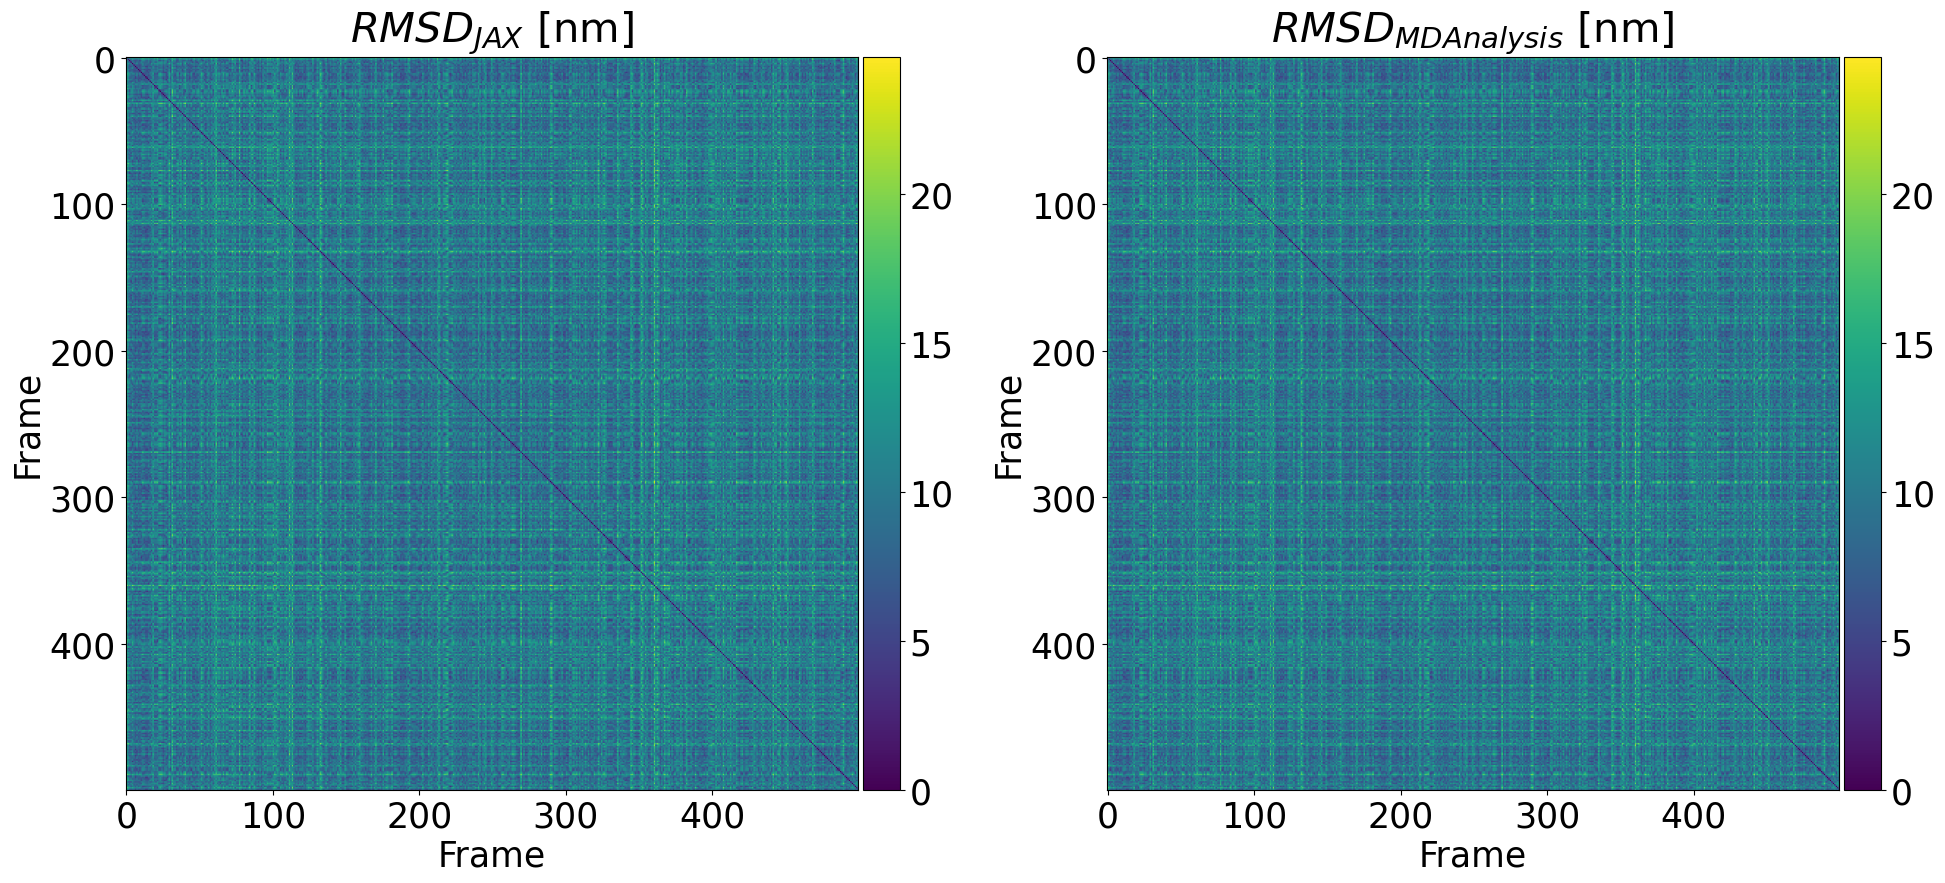

In [12]:
from mpl_toolkits.axes_grid1 import make_axes_locatable


fig, axes = plt.subplots(1,2, figsize = (20,20))
axes = axes.flatten()
im1 = axes[0].imshow(sym_prmsd_jax, cmap='viridis')
axes[0].set_xlabel('Frame')
axes[0].set_ylabel('Frame')
axes[0].set_title('$RMSD_{JAX}$ [nm]')


im2 = axes[1].imshow(mda_prmsd, cmap='viridis')
axes[1].set_xlabel('Frame')
axes[1].set_ylabel('Frame')
axes[1].set_title('$RMSD_{MDAnalysis}$ [nm]')


divider = make_axes_locatable(axes[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')

divider = make_axes_locatable(axes[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax, orientation='vertical')


fig.tight_layout()    
#fig.savefig('jax-mda-rmsd-heat-map-comparison.png',dpi=150)